In [121]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

sklearn.set_config(transform_output="pandas")
from tensorflow import keras

# tf.debugging.set_log_device_placement(True)

In [24]:
%matplotlib inline

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin


class LibraryLengthNormalizer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Normalise the gene counts to the library size
        X = X.apply(lambda x: (x / (x.sum() if x.sum() != 0 else 1)) * 1000000)
        return X


class DataNormalizerDESeq2(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Ensure all values are non-negative
        data = X.applymap(lambda x: max(x, 0))

        # Take the log
        log_data = np.log1p(data)

        # Calculate the pseudo-reference sample for each gene
        log_data["pseudo_reference"] = log_data.mean(axis=1)

        # Filter out genes with -Inf as their average
        filtered_log_data = log_data[log_data["pseudo_reference"] != float("-inf")]

        # Subtract the gene pseudo-references from log counts
        ratio_data = filtered_log_data.iloc[:, :-1].sub(
            filtered_log_data["pseudo_reference"], axis=0
        )

        # Find the median of the ratios for each sample
        sample_medians = ratio_data.median(axis=0)

        # Convert medians to scaling factors
        scaling_factors = np.exp(sample_medians)

        # Divide the original counts by the scaling factors
        X = data.div(scaling_factors)

        return X

In [8]:
keras.backend.clear_session()
keras.utils.set_random_seed(2)

In [4]:
file_name = "gene_counts_NN_55_training.csv"

data = pd.read_csv(file_name)
data_features = data.drop(columns=["sample"])
target = data["sample"]

In [113]:
from sklearn.model_selection import train_test_split

split_params = {
    "test_size": 0.2,
    "random_state": 0,
    "shuffle": True,
}


X_train, X_test, y_train, y_test = train_test_split(
    data_features,
    target,
    **split_params,
    stratify=target,
)

In [117]:
from sklearn.preprocessing import LabelEncoder


label_transformer = LabelEncoder()

y_train = label_transformer.fit_transform(y_train)
y_test = label_transformer.transform(y_test)

In [125]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    DropCorrelatedFeatures,
)
from sklearn.preprocessing import StandardScaler

feature_transformer = Pipeline(
    [
        ("drop_duplicates", DropDuplicateFeatures()),
        ("constant_feature_drop", DropConstantFeatures(tol=0.50)),
        ("normalise_for_library_size", LibraryLengthNormalizer()),
        (
            "drop correlating features",
            DropCorrelatedFeatures(variables=None, method="pearson", threshold=0.8),
        ),
        ("standard_scale", StandardScaler()),
    ]
)
print("Number of features before: ", X_train.shape[1])

X_train = feature_transformer.fit_transform(X_train)
X_test = feature_transformer.transform(X_test)

print("Number of features after: ", X_train.shape[1])

Number of features before:  2127
Number of features after:  2127


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x2117,x2118,x2119,x2120,x2121,x2122,x2123,x2124,x2125,x2126
0,1.172834,1.018988e+00,0.795209,1.202914,1.174896,0.653308,0.960203,-0.746674,0.864395,1.126595,...,-0.060012,1.048705,0.694624,0.876126,1.089223,1.217187,-0.866186,1.207572,-1.068388,-0.816100
1,-1.544436,-1.192433e+00,-0.337839,-0.466506,0.230071,-0.231170,-0.432619,3.164476,-2.503876,-0.814248,...,-2.700540,-1.909182,-0.154361,-0.257684,-3.903047,-0.782838,2.852077,-0.870987,0.975485,0.283137
2,0.821463,9.684001e-01,1.040421,1.013207,0.500021,1.095547,0.495929,-0.746674,0.724051,1.179051,...,0.820164,0.457128,0.694624,0.876126,1.089223,1.439412,-0.401403,1.077662,0.294194,-0.816100
3,0.165570,-2.001842e+00,-0.523862,-0.125034,0.365046,-0.673409,0.186413,0.817786,-0.258362,0.182401,...,-1.820364,0.457128,-0.578853,0.309221,-1.406912,0.328287,0.295771,0.168292,0.294194,-0.083276
4,-1.251627,-8.527702e-01,-0.388572,-0.997686,-0.309829,-1.115648,-0.432619,-0.746674,-0.398706,-1.601077,...,-0.940188,0.457128,-1.003345,-1.958399,-0.907685,-3.671764,0.063379,0.168292,1.656776,2.115198
5,0.001597,2.457135e-01,0.617642,0.747617,0.365046,-0.673409,0.031655,0.035556,0.724051,0.287312,...,0.820164,0.457128,0.270131,0.309221,-0.408458,-0.782838,-0.633795,0.168292,0.294194,0.283137
6,0.540366,6.720986e-01,0.693742,-0.162975,0.365046,-0.231170,1.114961,-0.746674,1.285429,0.549588,...,0.820164,-0.726027,0.694624,0.876126,0.589996,1.217187,-0.169012,0.298202,-0.387097,-0.449688
7,-0.853406,-4.805866e-01,-1.749921,0.292321,-0.309829,-0.673409,-0.742135,0.817786,-0.679396,-2.860002,...,-0.060012,-0.134449,-1.003345,-1.958399,-1.906139,-0.782838,0.528162,0.038382,2.338066,1.382374
8,0.329544,3.577299e-01,0.237141,-0.011210,0.095096,0.211069,0.805445,0.817786,1.004740,0.811864,...,0.820164,0.457128,0.270131,0.309221,0.090769,-0.338388,0.528162,0.558022,-0.387097,-0.449688
9,1.184547,1.243021e+00,1.150343,1.089090,1.309871,1.095547,1.114961,-0.746674,1.566118,1.336416,...,0.820164,1.048705,1.119116,0.876126,0.589996,1.217187,-1.098578,1.467392,-1.068388,-0.816100


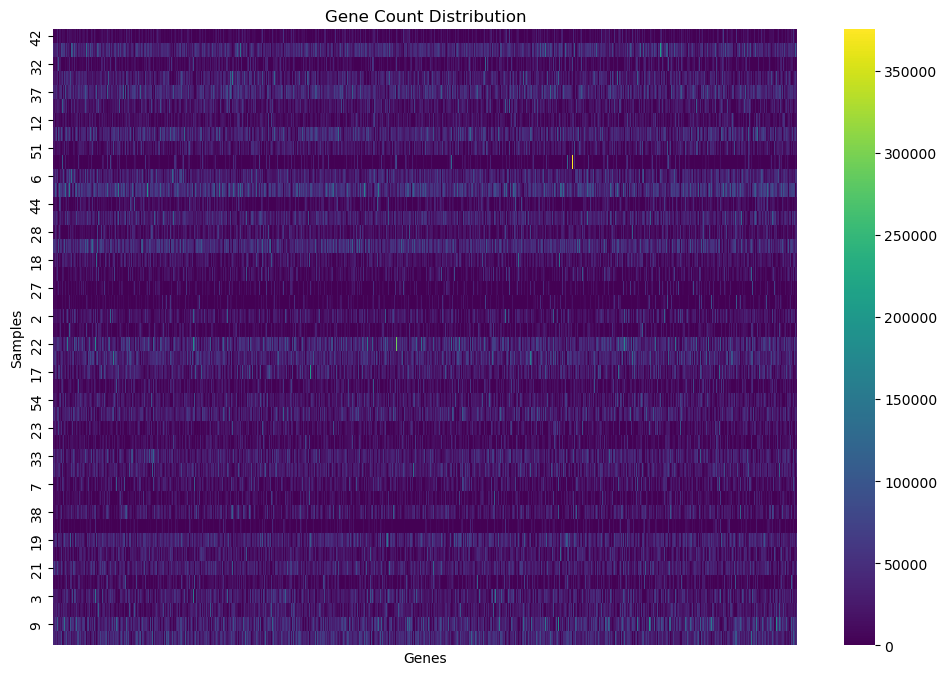

In [17]:
# Create a heatmap for the gene count distribution
# Without standard scaler
plt.figure(figsize=(12, 8))
sns.heatmap(X_train, cmap="viridis", cbar=True, xticklabels=False)
plt.title("Gene Count Distribution")
plt.ylabel("Samples")
plt.xlabel("Genes")
plt.show()

In [ ]:
# Select a subset of genes for visualization (e.g., the first 10 genes)
subset_genes = X_train.columns[:20]

# Calculate the number of rows and columns based on the number of genes
num_genes = len(subset_genes)
num_cols = min(num_genes, 6)  # Maximum 6 columns
num_rows = (num_genes - 1) // num_cols + 1  # Calculate the number of rows

# Create subplots for each gene's distribution
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols)

# Flatten the axes array if necessary
if num_genes < 6:
    axes = axes.reshape(1, -1)

for i, gene in enumerate(subset_genes):
    row_idx = i // num_cols
    col_idx = i % num_cols
    sns.histplot(data=X_train[gene], ax=axes[row_idx, col_idx], kde=True, color="blue")
    axes[row_idx, col_idx].set_title(f"Distribution of {gene}")
    axes[row_idx, col_idx].set_xlabel("Gene Count")
    axes[row_idx, col_idx].set_ylabel("Frequency")

# Remove empty subplots if necessary
for i in range(num_genes, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

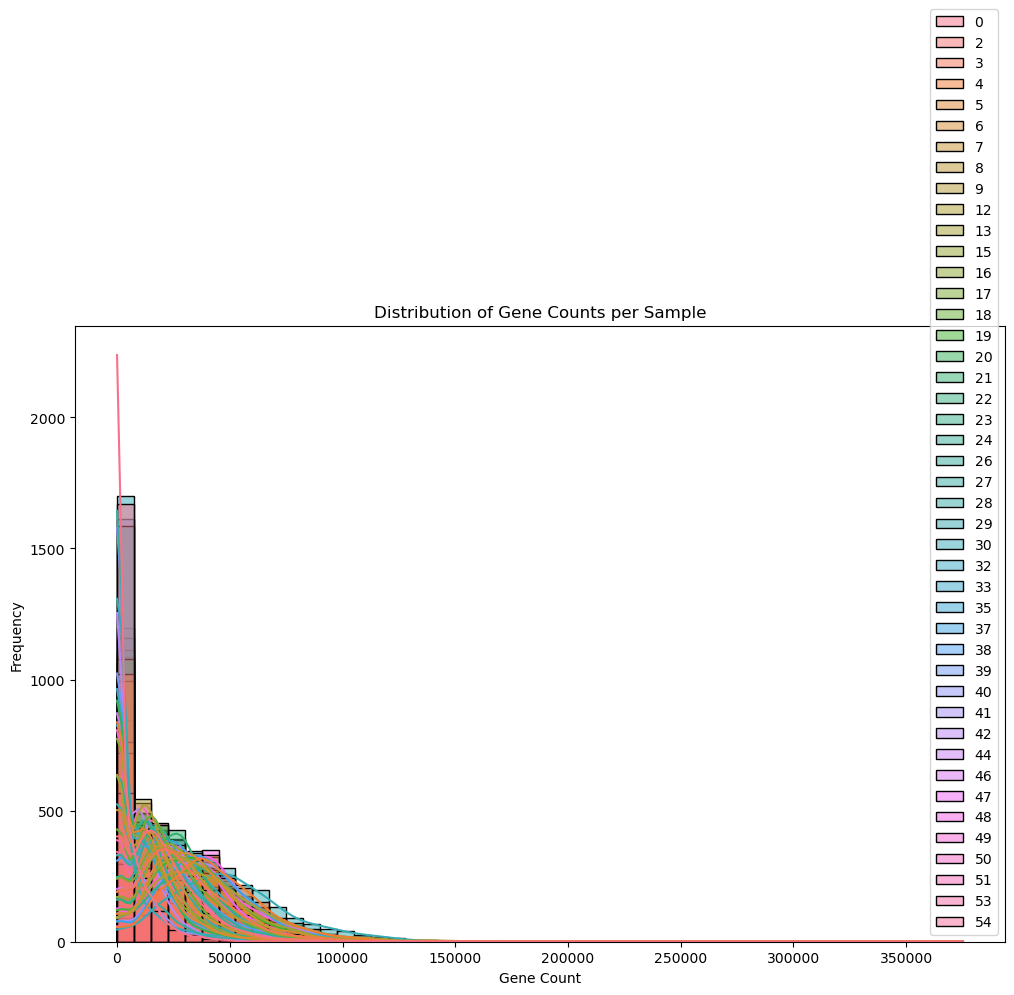

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create histograms for gene counts per sample
plt.figure(figsize=(12, 8))
sns.histplot(
    data=X_train.T, kde=True, color="blue", bins=50
)  # Transpose X_train for sample-wise plotting
plt.title("Distribution of Gene Counts per Sample")
plt.xlabel("Gene Count")
plt.ylabel("Frequency")
plt.show()

In [12]:
params = {
    "activation": "relu",
    "alpha": 0.0001,
    "batch_size": "auto",
    "beta_1": 0.9,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100,),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_fun": 15000,
    "max_iter": 600,
    "momentum": 0.9,
    "n_iter_no_change": 10,
    "nesterovs_momentum": True,
    "power_t": 0.5,
    "random_state": 0,
    "shuffle": True,
    "solver": "adam",
    "tol": 0.0001,
    "validation_fraction": 0.1,
    "verbose": False,
    "warm_start": False,
}

In [14]:
from sklearn.svm import SVC, LinearSVC

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score


svc = LinearSVC()
svcp = SVC(kernel="poly", degree=3, C=1)
svmrbf = SVC(kernel="rbf", gamma=0.7, C=1)
mlpc = MLPClassifier(**params)
knc = KNeighborsClassifier(n_neighbors=2)
rfc = RandomForestClassifier(max_depth=2, n_estimators=25)

models = {
    "scv": svc,
    "poly": svcp,
    "rbf": svmrbf,
    "mlpc": mlpc,
    "K nearest neighbours": knc,
    "random forest": rfc,
}

scaler = StandardScaler()


model_names = []
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    complete_pipeline = Pipeline(
        [
            ("StandardScaler", scaler),
            ("Model Training", model),
        ]
    )
    # model fitting
    complete_pipeline.fit(X_train, y_train)

    # model scoring
    train_pred = complete_pipeline.predict(X_train)
    test_pred = complete_pipeline.predict(X_test)

    # Evaluate model performance
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred, average="macro")
    test_f1 = f1_score(y_test, test_pred, average="macro")

    # Print model performance
    print("*" * 50)
    print(f"{name} Training score:")
    print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
    print("-" * 20)
    print(f"{name} Validation score:")
    print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

    # Append model name and metrics to lists
    model_names.append(name)
    accuracy_scores.append(test_accuracy)
    f1_scores.append(test_f1)

/home/t.afanasyeva/mambaforge/envs/MATseq/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


**************************************************
scv Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
scv Validation score:
Accuracy: 0.5455 | F1 score: 0.3704
**************************************************
poly Training score:
Accuracy: 0.6136 | F1 score: 0.4714
--------------------
poly Validation score:
Accuracy: 0.1818 | F1 score: 0.0889
**************************************************
rbf Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
rbf Validation score:
Accuracy: 0.1818 | F1 score: 0.0342
**************************************************
mlpc Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
mlpc Validation score:
Accuracy: 0.2727 | F1 score: 0.1556
**************************************************
K nearest neighbours Training score:
Accuracy: 0.5909 | F1 score: 0.6159
--------------------
K nearest neighbours Validation score:
Accuracy: 0.2727 | F1 score: 0.1296
**************************************************

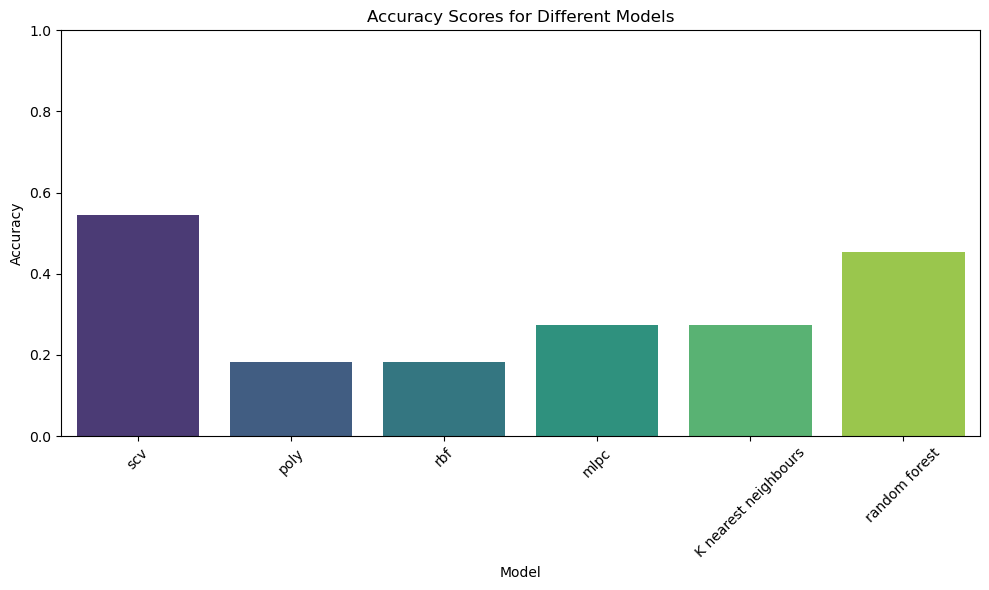

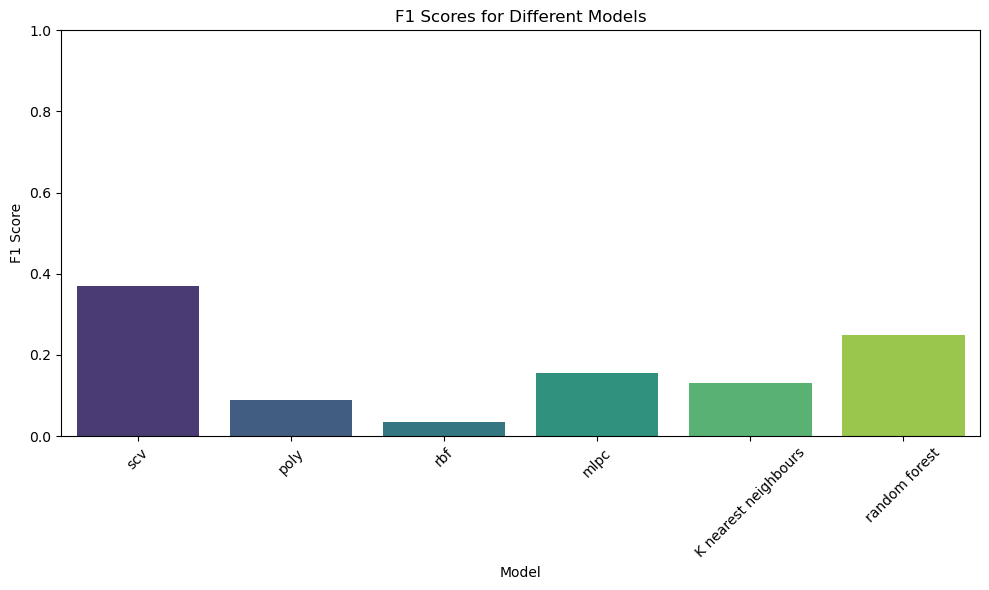

In [15]:
# Create a barplot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")
plt.title("Accuracy Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Create a barplot for F1 score
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.title("F1 Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for F1 score)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

Poly kernel SVC does not perfomr so well, I will substitute it with GaussianNB and tree-derived XGBoost

In [48]:
from sklearn.svm import SVC, LinearSVC

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier


svc = SVC(kernel="linear", probability=True, gamma=0.7, C=1)
svmrbf = SVC(kernel="rbf", probability=True, gamma=0.7, C=1)
mlpc = MLPClassifier(**params)
knc = KNeighborsClassifier(n_neighbors=3)
rfc = RandomForestClassifier(max_depth=2, n_estimators=30)
nb = GaussianNB()
bst = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)
ext = ExtraTreesClassifier(n_estimators=30, max_depth=2)
eclf = VotingClassifier(
    estimators=[
        ("LinearSVC", svc),
        ("SVCRBF", svmrbf),
        ("MLPClassifier", mlpc),
        ("KNeighborsClassifier", knc),
        ("RandomForestClassifier", rfc),
        ("GaussianNB", nb),
        ("XGBClassifier", bst),
        ("ExtraTreesClassifier", ext),
    ],
    voting="soft",
    n_jobs=-1,
)


models = {
    "LinearSVC": svc,
    "RBF_SVC": svmrbf,
    "MLPClassifier": mlpc,
    "KNeighborsClassifier": knc,
    "RandomForestClassifier": rfc,
    "GaussianNB": nb,
    "XGBClassifier": bst,
    "ExtraTreesClassifier": ext,
    "VotingClassifier": eclf,
}


scaler = StandardScaler()


model_names = []
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    complete_pipeline = Pipeline(
        [
            ("StandardScaler", scaler),
            ("Model Training", model),
        ]
    )
    # model fitting
    complete_pipeline.fit(X_train, y_train)

    # model scoring
    train_pred = complete_pipeline.predict(X_train)
    test_pred = complete_pipeline.predict(X_test)

    # Evaluate model performance
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred, average="macro")
    test_f1 = f1_score(y_test, test_pred, average="macro")

    # Print model performance
    print("*" * 50)
    print(f"{name} Training score:")
    print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
    print("-" * 20)
    print(f"{name} Validation score:")
    print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

    # Append model name and metrics to lists
    model_names.append(name)
    accuracy_scores.append(test_accuracy)
    f1_scores.append(test_f1)

**************************************************
LinearSVC Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
LinearSVC Validation score:
Accuracy: 0.5455 | F1 score: 0.3963
**************************************************
RBF_SVC Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
RBF_SVC Validation score:
Accuracy: 0.1818 | F1 score: 0.0342
**************************************************
MLPClassifier Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
MLPClassifier Validation score:
Accuracy: 0.2727 | F1 score: 0.1556
**************************************************
KNeighborsClassifier Training score:
Accuracy: 0.5909 | F1 score: 0.6159
--------------------
KNeighborsClassifier Validation score:
Accuracy: 0.2727 | F1 score: 0.1296
**************************************************
RandomForestClassifier Training score:
Accuracy: 0.7955 | F1 score: 0.6384
--------------------
RandomForestClassifier Validation score:
Accuracy: 0.

In [33]:
from sklearn.utils import all_estimators

estimators = all_estimators()

for name, class_ in estimators:
    if hasattr(class_, "predict_proba"):
        print(name)

AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


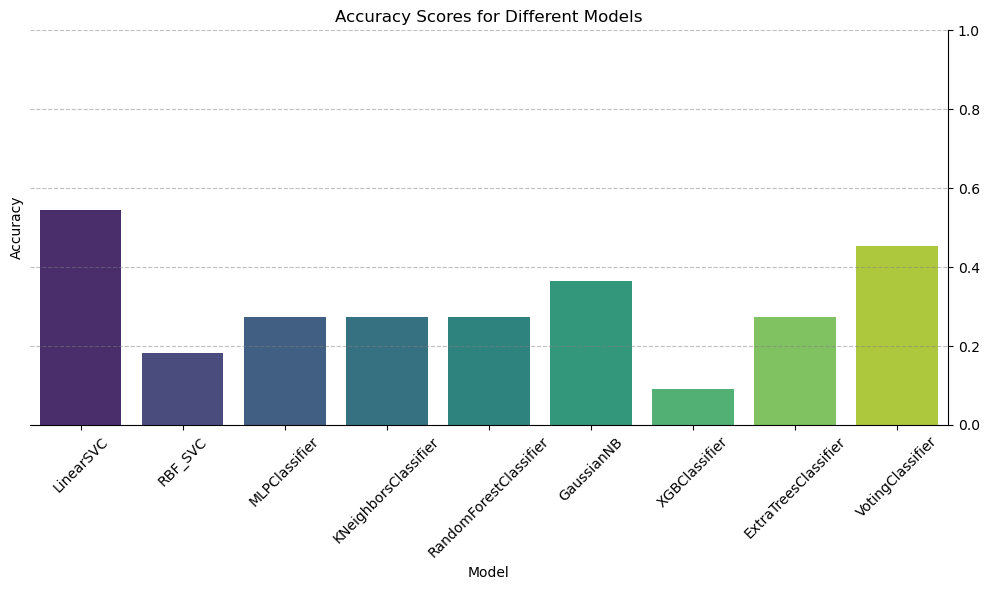

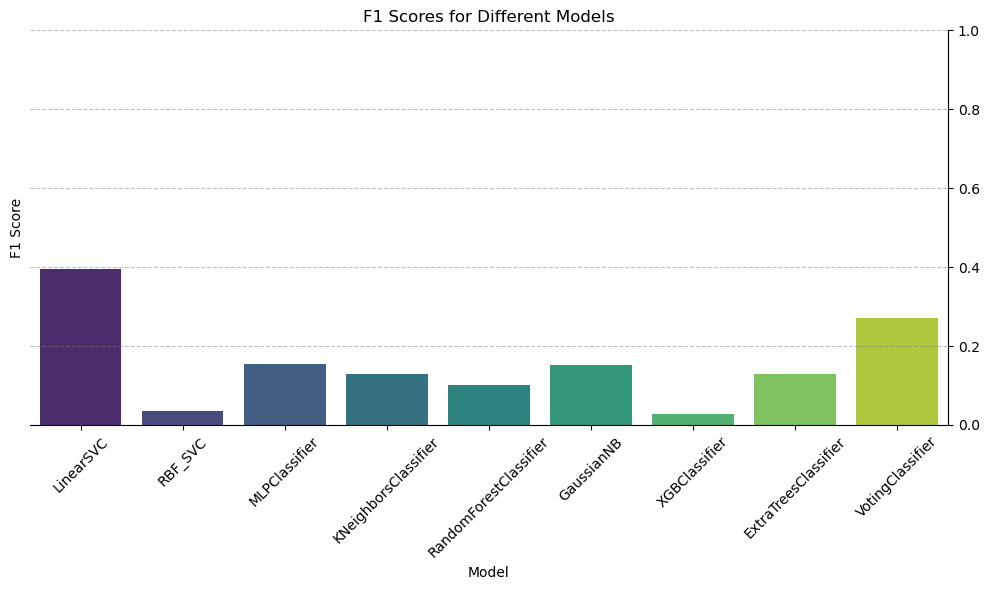

In [46]:
# Create a barplot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")
plt.title("Accuracy Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

# Create a barplot for F1 score
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.title("F1 Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for F1 score)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

Will try with leave-on-out 

In [52]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
predicted_labels = []

model_names = []
accuracy_scores = []
f1_scores = []

for train_index, test_index in loo.split(data_features):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    y_train = label_transformer.fit_transform(y_train)
    y_test = label_transformer.transform(y_test)

    for name, model in models.items():
        complete_pipeline = Pipeline(
            [
                ("StandardScaler", scaler),
                ("Model Training", model),
            ]
        )
        # model fitting
        complete_pipeline.fit(X_train, y_train)

        # model scoring
        train_pred = complete_pipeline.predict(X_train)
        test_pred = complete_pipeline.predict(X_test)

        # Evaluate model performance
        train_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)
        train_f1 = f1_score(y_train, train_pred, average="macro")
        test_f1 = f1_score(y_test, test_pred, average="macro")

        # Print model performance
        print("*" * 50)
        print(f"{name} Training score:")
        print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
        print("-" * 20)
        print(f"{name} Validation score:")
        print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

        # Append model name and metrics to lists
        model_names.append(name)
        accuracy_scores.append(test_accuracy)
        f1_scores.append(test_f1)

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54] TEST: [0]
**************************************************
LinearSVC Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
LinearSVC Validation score:
Accuracy: 0.0 | F1 score: 0.0
**************************************************
RBF_SVC Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
RBF_SVC Validation score:
Accuracy: 0.0 | F1 score: 0.0
**************************************************
MLPClassifier Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
MLPClassifier Validation score:
Accuracy: 0.0 | F1 score: 0.0
**************************************************
KNeighborsClassifier Training score:
Accuracy: 0.6852 | F1 score: 0.6372
--------------------
KNeighborsClassifier Validation score:
Accuracy: 0.0 | F1 score: 0.0
*****************************************

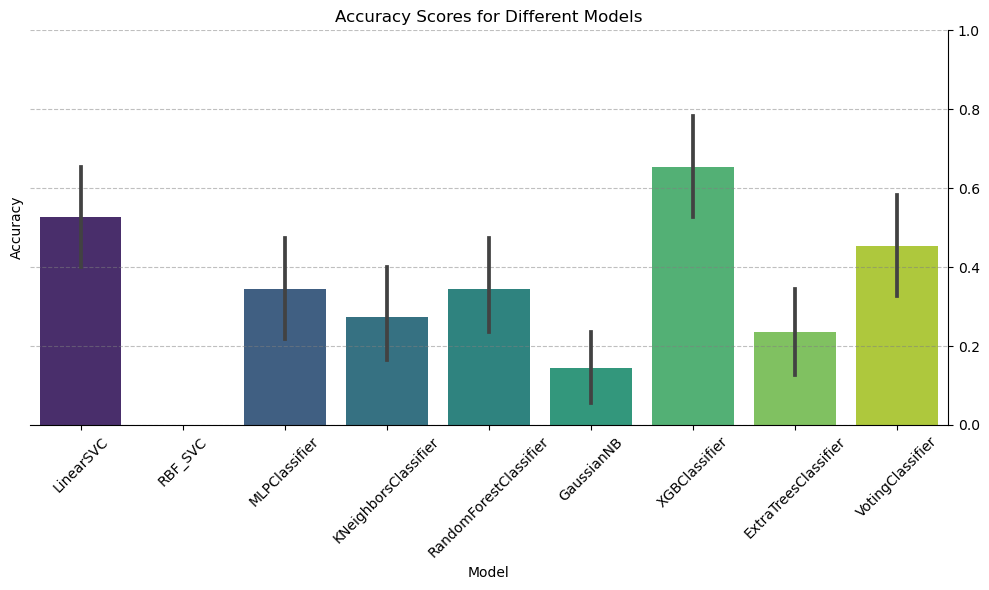

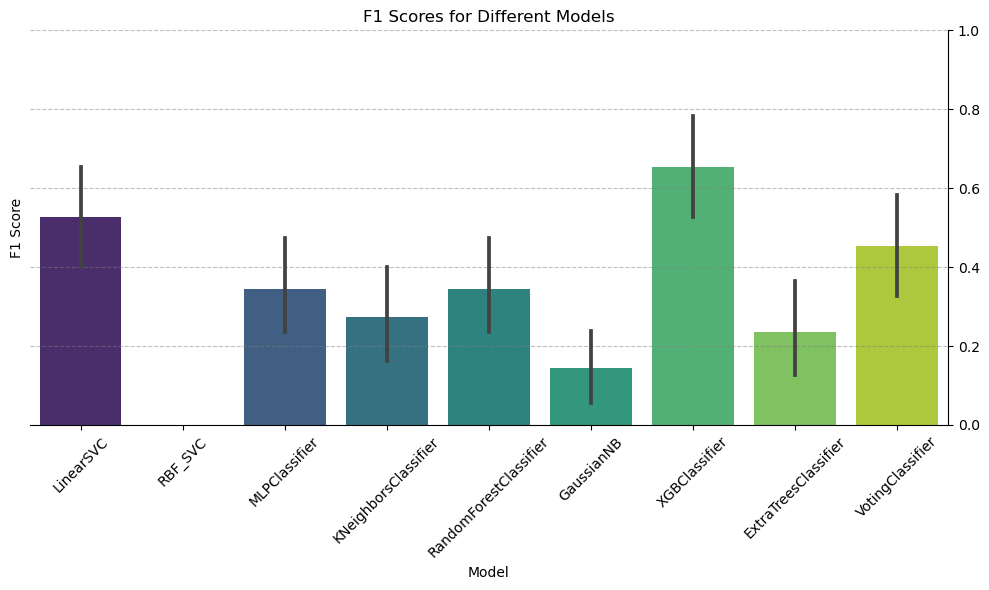

In [53]:
# Create a barplot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")
plt.title("Accuracy Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

# Create a barplot for F1 score
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.title("F1 Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for F1 score)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
predicted_labels = []

model_names = []
accuracy_scores = []
f1_scores = []

for train_index, test_index in loo.split(data_features):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    y_train = label_transformer.fit_transform(y_train)
    y_test = label_transformer.transform(y_test)

    for name, model in models.items():
        complete_pipeline = Pipeline(
            [
                ("StandardScaler", scaler),
                ("Model Training", model),
            ]
        )
        # model fitting
        complete_pipeline.fit(X_train, y_train)

        # model scoring
        train_pred = complete_pipeline.predict(X_train)
        test_pred = complete_pipeline.predict(X_test)

        # Evaluate model performance
        train_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)
        train_f1 = f1_score(y_train, train_pred, average="macro")
        test_f1 = f1_score(y_test, test_pred, average="macro")

        # Print model performance
        print("*" * 50)
        print(f"{name} Training score:")
        print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
        print("-" * 20)
        print(f"{name} Validation score:")
        print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

        # Append model name and metrics to lists
        model_names.append(name)
        accuracy_scores.append(test_accuracy)
        f1_scores.append(test_f1)

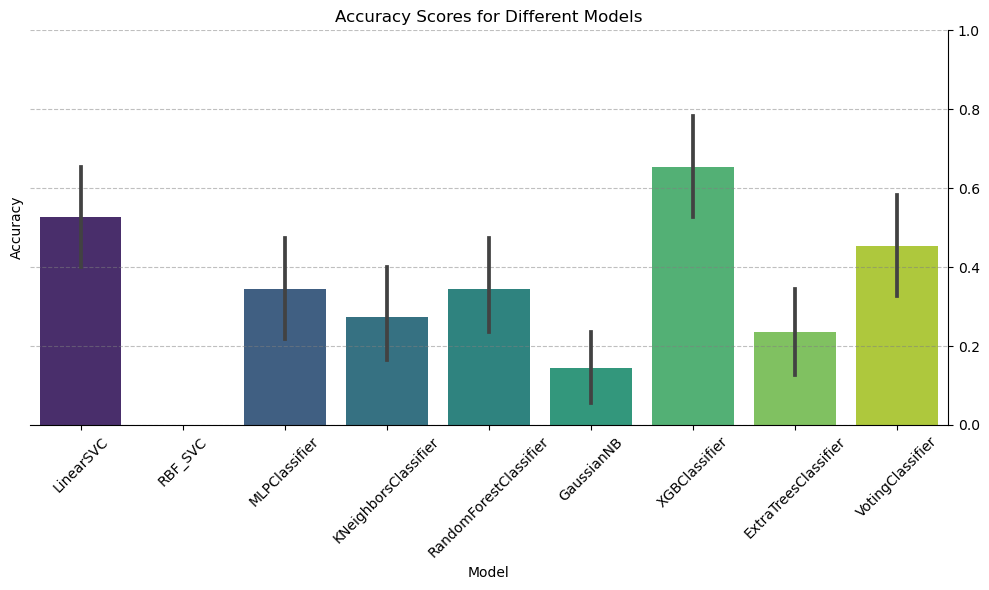

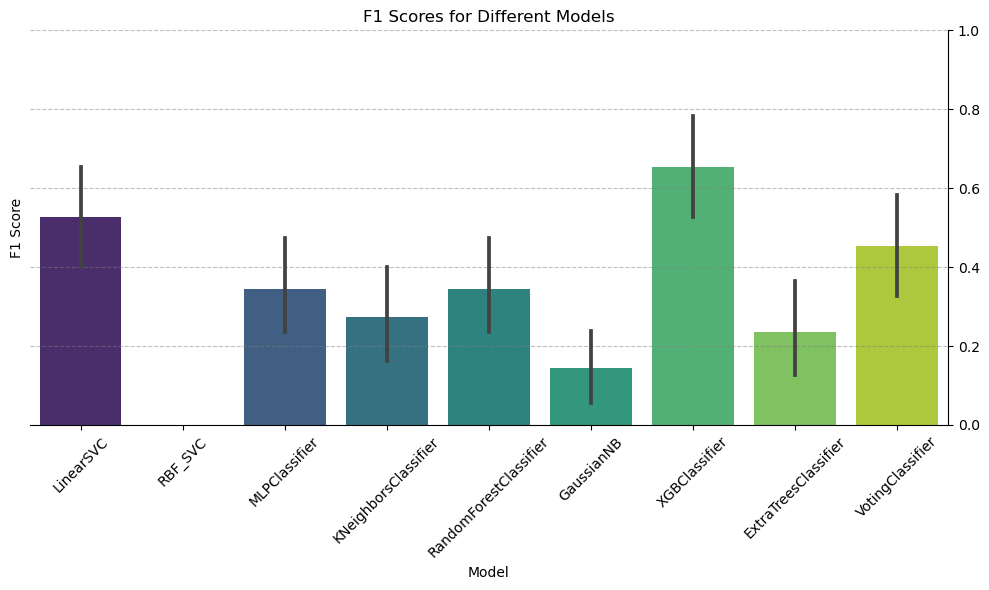

In [ ]:
# Create a barplot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")
plt.title("Accuracy Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

# Create a barplot for F1 score
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.title("F1 Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for F1 score)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

In [62]:
from sklearn.svm import SVC, LinearSVC

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier


svc = SVC(kernel="linear", probability=True, gamma=0.7, C=1)
svmrbf = SVC(kernel="rbf", probability=True, gamma=0.7, C=1)
mlpc = MLPClassifier(**params)
knc = KNeighborsClassifier(n_neighbors=4)
rfc = RandomForestClassifier(max_depth=3, n_estimators=50)
nb = GaussianNB()
bst = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)
ext = ExtraTreesClassifier(n_estimators=50, max_depth=3)
eclf = VotingClassifier(
    estimators=[
        ("LinearSVC", svc),
        ("MLPClassifier", mlpc),
        ("KNeighborsClassifier", knc),
        ("RandomForestClassifier", rfc),
        ("GaussianNB", nb),
        ("XGBClassifier", bst),
        ("ExtraTreesClassifier", ext),
    ],
    voting="soft",
    n_jobs=-1,
)


models = {
    "LinearSVC": svc,
    "MLPClassifier": mlpc,
    "KNeighborsClassifier": knc,
    "RandomForestClassifier": rfc,
    "GaussianNB": nb,
    "XGBClassifier": bst,
    "ExtraTreesClassifier": ext,
    "VotingClassifier": eclf,
}

In [56]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
scaler = StandardScaler()

predicted_labels = []
model_names = []
accuracy_scores = []
f1_scores = []


for train_index, test_index in loo.split(data_features):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = data_features.iloc[train_index], data_features.iloc[test_index]
    y_train, y_test = target[train_index], target[test_index]

    y_train = label_transformer.fit_transform(y_train)
    y_test = label_transformer.transform(y_test)

    for name, model in models.items():
        complete_pipeline = Pipeline(
            [
                ("StandardScaler", scaler),
                ("Model Training", model),
            ]
        )
        # model fitting
        complete_pipeline.fit(X_train, y_train)

        # model scoring
        train_pred = complete_pipeline.predict(X_train)
        test_pred = complete_pipeline.predict(X_test)

        # Evaluate model performance
        train_accuracy = accuracy_score(y_train, train_pred)
        test_accuracy = accuracy_score(y_test, test_pred)
        train_f1 = f1_score(y_train, train_pred, average="macro")
        test_f1 = f1_score(y_test, test_pred, average="macro")

        # Print model performance
        print("*" * 50)
        print(f"{name} Training score:")
        print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
        print("-" * 20)
        print(f"{name} Validation score:")
        print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

        # Append model name and metrics to lists
        model_names.append(name)
        accuracy_scores.append(test_accuracy)
        f1_scores.append(test_f1)

TRAIN: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54] TEST: [0]
**************************************************
LinearSVC Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
LinearSVC Validation score:
Accuracy: 0.0 | F1 score: 0.0
**************************************************
MLPClassifier Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
MLPClassifier Validation score:
Accuracy: 0.0 | F1 score: 0.0
**************************************************
KNeighborsClassifier Training score:
Accuracy: 0.6852 | F1 score: 0.6372
--------------------
KNeighborsClassifier Validation score:
Accuracy: 0.0 | F1 score: 0.0
**************************************************
RandomForestClassifier Training score:
Accuracy: 0.7593 | F1 score: 0.6232
--------------------
RandomForestClassifier Validation score:
Accuracy: 0.0 | F1 score: 0.0
*****

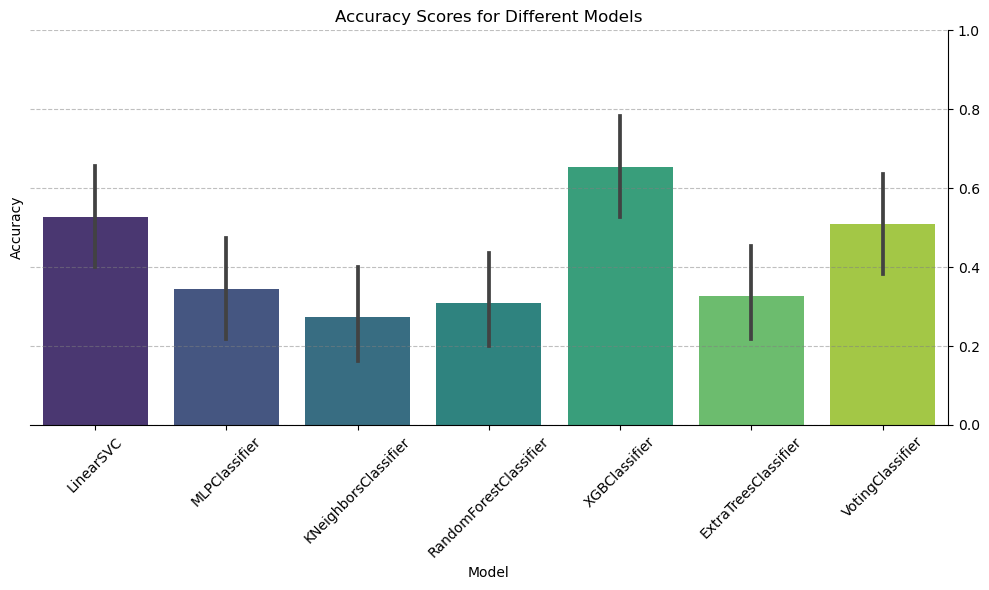

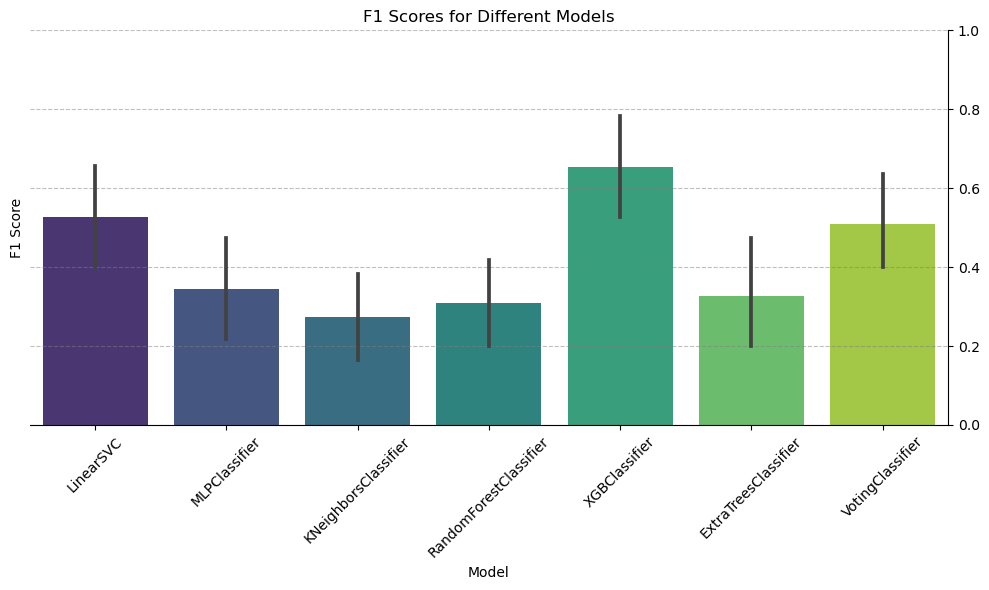

In [57]:
# Create a barplot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")
plt.title("Accuracy Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

# Create a barplot for F1 score
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.title("F1 Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for F1 score)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

In [76]:
mc = VotingClassifier(
    estimators=[
        ("LinearSVC", svc),
        ("RandomForestClassifier", rfc),
        ("GaussianNB", nb),
        ("XGBClassifier", bst),
        ("ExtraTreesClassifier", ext),
    ],
    voting="soft",
)

In [81]:
from sklearn.ensemble import BaggingClassifier

bag_multi = BaggingClassifier(
    estimator=XGBClassifier(),
    n_estimators=500,
    max_features=100,
    max_samples=0.5,
    bootstrap=True,
    bootstrap_features=True,
    warm_start=False,
)

In [82]:
# model fitting
bag_multi.fit(X_train, y_train)

# model scoring
train_pred = bag_multi.predict(X_train)
test_pred = bag_multi.predict(X_test)

# Evaluate model performance
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
train_f1 = f1_score(y_train, train_pred, average="macro")
test_f1 = f1_score(y_test, test_pred, average="macro")

# Print model performance
print("*" * 50)
print("BaggingClassifier Training score:")
print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
print("-" * 20)
print("BaggingClassifier Validation score:")
print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

**************************************************
BaggingClassifier Training score:
Accuracy: 1.0 | F1 score: 1.0
--------------------
BaggingClassifier Validation score:
Accuracy: 1.0 | F1 score: 1.0


In [95]:
from joblib import dump, load

dump(bag_multi, "BaggingClassifier.joblib")

['BaggingClassifier.joblib']

In [ ]:
# Create a barplot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")
plt.title("Accuracy Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

# Create a barplot for F1 score
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.title("F1 Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for F1 score)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

In [104]:
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(n_estimators=50, estimator=svc, learning_rate=1)

# model fitting
abc.fit(X_train, y_train)

# model scoring
train_pred = abc.predict(X_train)
test_pred = abc.predict(X_test)

# Evaluate model performance
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
train_f1 = f1_score(y_train, train_pred, average="macro")
test_f1 = f1_score(y_test, test_pred, average="macro")

name = "AdaBoostClassifier"

# Print model performance
print("*" * 50)
print(f"{name} Training score:")
print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
print("-" * 20)
print(f"{name} Validation score:")
print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

**************************************************
AdaBoostClassifier Training score:
Accuracy: 0.7593 | F1 score: 0.6567
--------------------
AdaBoostClassifier Validation score:
Accuracy: 1.0 | F1 score: 1.0


In [109]:
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier


svc = SVC(kernel="linear", probability=True, gamma=0.7, C=1)
svmrbf = SVC(kernel="rbf", probability=True, gamma=0.7, C=1)
mlpc = MLPClassifier(**params)
knc = KNeighborsClassifier(n_neighbors=4)
rfc = RandomForestClassifier(max_depth=3, n_estimators=50)
nb = GaussianNB()
bst = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)
ext = ExtraTreesClassifier(n_estimators=50, max_depth=3)
eclf = VotingClassifier(
    estimators=[
        ("LinearSVC", svc),
        ("MLPClassifier", mlpc),
        ("KNeighborsClassifier", knc),
        ("RandomForestClassifier", rfc),
        ("GaussianNB", nb),
        ("XGBClassifier", bst),
        ("ExtraTreesClassifier", ext),
    ],
    voting="soft",
    n_jobs=-1,
)
abc = AdaBoostClassifier(
    n_estimators=50,
    estimator=[
        ("RandomForestClassifier", rfc),
        ("XGBClassifier", bst),
        ("ExtraTreesClassifier", ext),
    ],
    learning_rate=1,
)

models = {
    "LinearSVC": svc,
    "MLPClassifier": mlpc,
    "KNeighborsClassifier": knc,
    "RandomForestClassifier": rfc,
    "GaussianNB": nb,
    "XGBClassifier": bst,
    "ExtraTreesClassifier": ext,
    "VotingClassifier": eclf,
    "AdaBoostClassifier": abc,
}

In [ ]:
model_names = []
accuracy_scores = []
f1_scores = []

for name, model in models.items():
    complete_pipeline = Pipeline(
        [
            ("StandardScaler", scaler),
            ("Model Training", model),
        ]
    )
    # model fitting
    complete_pipeline.fit(X_train, y_train)

    # model scoring
    train_pred = complete_pipeline.predict(X_train)
    test_pred = complete_pipeline.predict(X_test)

    # Evaluate model performance
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred, average="macro")
    test_f1 = f1_score(y_test, test_pred, average="macro")

    # Print model performance
    print("*" * 50)
    print(f"{name} Training score:")
    print(f"Accuracy: {round(train_accuracy, 4)} | F1 score: {round(train_f1, 4)}")
    print("-" * 20)
    print(f"{name} Validation score:")
    print(f"Accuracy: {round(test_accuracy, 4)} | F1 score: {round(test_f1, 4)}")

    # Append model name and metrics to lists
    model_names.append(name)
    accuracy_scores.append(test_accuracy)
    f1_scores.append(test_f1)

In [ ]:
# Create a barplot for accuracy
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracy_scores, palette="viridis")
plt.title("Accuracy Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

# Create a barplot for F1 score
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=f1_scores, palette="viridis")
plt.title("F1 Scores for Different Models")
plt.ylim(0, 1)  # Set the y-axis limits (0 to 1 for F1 score)
plt.ylabel("F1 Score")
plt.xlabel("Model")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

ax = plt.gca()
ax.yaxis.grid(True, linestyle="--", alpha=0.5, color="grey")
sns.despine(left=True, right=False, top=True)

plt.tight_layout()
plt.show()

In [112]:
X_train.shape

(54, 19992)

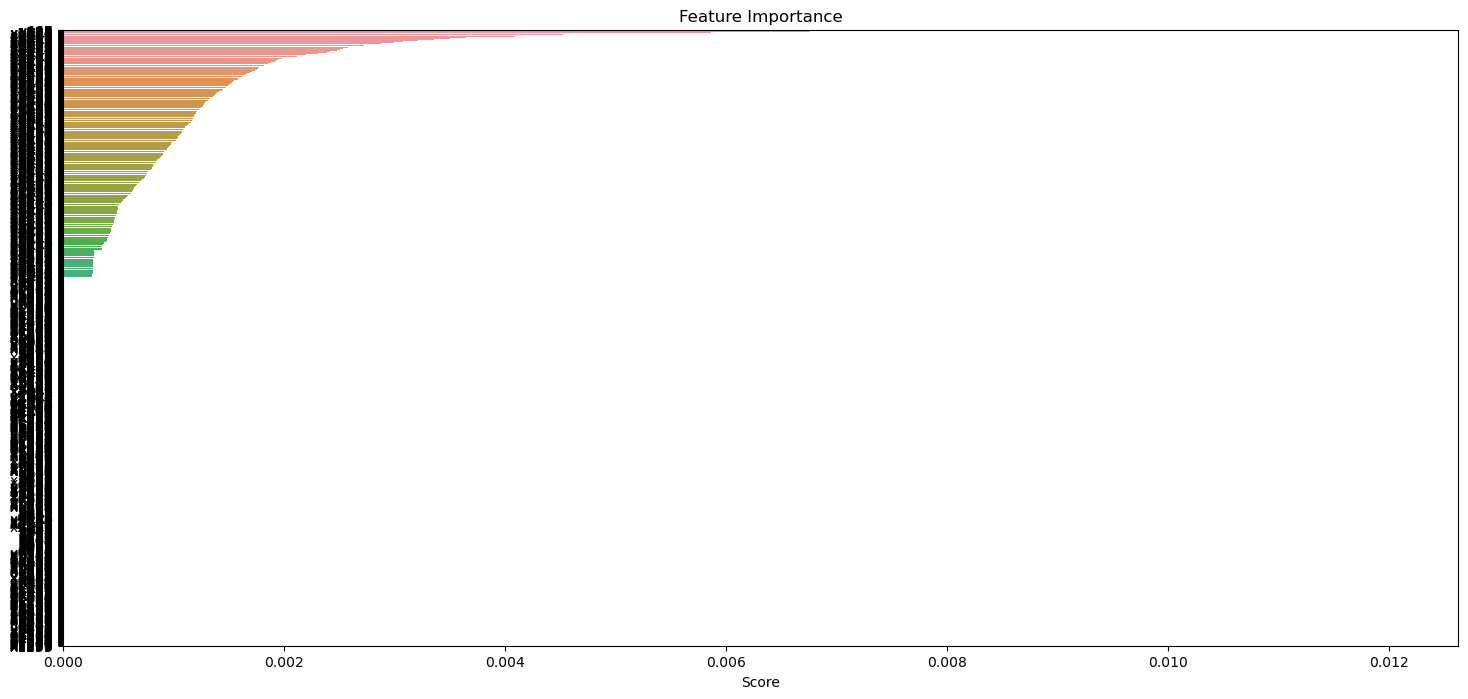

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

fig = plt.figure(figsize=(18, 8))
importance = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(
    ascending=False
)
sns.barplot(x=importance, y=importance.index)
plt.title("Feature Importance")
plt.xlabel("Score")
plt.show()